## Fitting the VDP oscillator

In [1]:
import numpy as np
import functorch

import torch
import torch.nn as nn

from torch_vector_field import utilities, plotting, vector_field, data_utils, net, train_utils

In [2]:
class SmoothTransformationVectorField(nn.Module):
    """Wrapper for applying a smooth transformation to space to warp a vector field.

    v: An underlying vector field which gets transformed
    f: A parametric diffeomorphism between manifolds
    """

    def __init__(self, v: nn.Module, f: nn.Module):
        super(SmoothTransformationVectorField, self).__init__()
        self.v = v
        self.f = f
        self.device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")

        f_fn, f_params, f_buffers = functorch.make_functional_with_buffers(f.to(self.device))

        def f_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            return f_fn(f_params, f_buffers, x)

        self.grad_f_fn = functorch.jacfwd(f_forward_fn)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        Df = functorch.vmap(self.grad_f_fn)(x)
        Df_inv = functorch.vmap(torch.linalg.inv)(Df)
        vfx =  self.v(self.f(x))
        out = functorch.vmap(lambda x, y: x @ y)(Df_inv, vfx)
        return out

In [3]:
import icnn

class GeneralPotentialField(nn.Module):
    def __init__(self):
        super(GeneralPotentialField, self).__init__()
        self.net = icnn.PartiallyInputConvexNeuralNetwork([2,16,1], [1,16,1])

    def forward(self, x):
        r, x_unit = net.radial_coordinate_transform(x)
        return self.net(x_unit, r)

Define a few different model architectures, with varying levels of expressive power

In [4]:
def build_full_net():
    """ An expressive parametric CPG, with latent-state dynamics modelling """
    potential_field = GeneralPotentialField()
    rotational_field = net.SimpleRotationalField()
    combined_field = net.LinearCombinationWrapper(
        net.GradientWrapper(potential_field, positive=False),
        rotational_field
    )

    smooth_transformation = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8, 2)
    )
    transformed_field = SmoothTransformationVectorField(combined_field, smooth_transformation)
    return transformed_field

def build_baseline_1():
    """ A simple circular (no parameters) CPG """
    potential_field = net.SimplePotentialField()
    rotational_field = net.SimpleRotationalField()
    combined_field = net.LinearCombinationWrapper(
        net.GradientWrapper(potential_field, positive=False),
        rotational_field
    )
    return combined_field

def build_baseline_2():
    """ Latent-state dynamics modelling, with a simple CPG """
    potential_field = net.SimplePotentialField()
    rotational_field = net.SimpleRotationalField()
    combined_field = net.LinearCombinationWrapper(
        net.GradientWrapper(potential_field, positive=False),
        rotational_field
    )
    smooth_transformation = nn.Sequential(
        nn.Linear(2, 64),
        nn.ELU(),
        nn.Linear(64, 64),
        nn.ELU(),
        nn.Linear(64, 2)
    )
    transformed_field = SmoothTransformationVectorField(combined_field, smooth_transformation)
    return transformed_field

def build_baseline_3():
    """Arbitrary NODE dynamics """
    vector_field = nn.Sequential(
        nn.Linear(2, 64),
        nn.ELU(),
        nn.Linear(64, 64),
        nn.ELU(),
        nn.Linear(64, 2)
    )
    return vector_field

def build_baseline_4():
    """Arbitrary NODE dynamics with latent state embedding """
    vector_field = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8,2)
    )
    smooth_transformation = nn.Sequential(
        nn.Linear(2, 64),
        nn.ELU(),
        nn.Linear(64, 64),
        nn.ELU(),
        nn.Linear(64, 2)
    )
    transformed_field = SmoothTransformationVectorField(vector_field, smooth_transformation)
    return transformed_field

In [5]:
baseline_1 = build_baseline_1()
baseline_2 = build_baseline_2()
baseline_3 = build_baseline_3()
baseline_4 = build_baseline_4()
full_net = build_full_net()

Load the dataset

In [6]:
x_train, dx_train = data_utils.load_dataset('van_der_pol_train')

train_ds = torch.utils.data.TensorDataset(
    torch.from_numpy(x_train.astype(np.float32)), 
    torch.from_numpy(dx_train.astype(np.float32))
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 128)

## Fitting the Model

[0.017686475068330765, 0.056771465577185154, 0.03186905011534691, 0.05208525061607361, 0.017688054591417313, 0.05739934090524912, 0.03195314109325409, 0.053178876638412476, 0.01915418729186058, 0.05964365042746067]


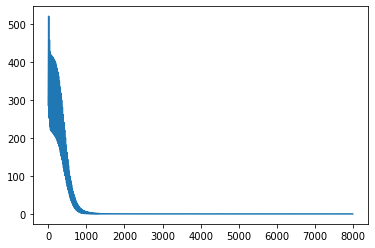

In [7]:
loss_history = train_utils.train(baseline_3, train_loader, learning_rate=1e-3, n_epochs = 2000, grad_clip=5)
import matplotlib.pyplot as plt 
plt.plot(10 * np.arange(len(loss_history)), loss_history)
print(loss_history[-10:])

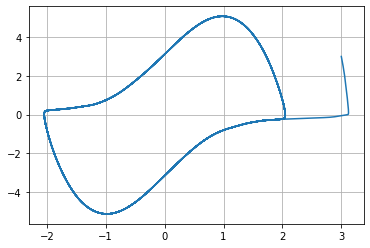

In [8]:
model = baseline_3
model.eval()
model.to("cpu")
learned_field_wrapper = vector_field.TorchToNumpyVectorFieldWrapper(model)
h = utilities.simulate_trajectory(learned_field_wrapper, np.array([3.0, 3.0]), ascending=True, num_iters = 10000, grad_clip=0.5)
plotting.plot_histories([h])

The arbitrary NODE dynamics with latent state embedding should be strictly more expressive. We investigate whether this is empirically the case

[0.13353925943374634, 0.6046767234802246, 0.13350428640842438, 0.6044865250587463, 0.1334693878889084, 0.6042960658669472, 0.13343462347984314, 0.6041062921285629, 0.13339963555335999, 0.6039166003465652]


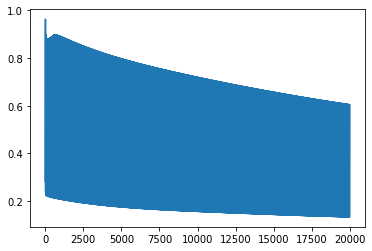

In [13]:
loss_history = train_utils.train(baseline_4, train_loader, learning_rate=1e-5, n_epochs = 5000, grad_clip=5)
import matplotlib.pyplot as plt 
plt.plot(10 * np.arange(len(loss_history)), loss_history)
print(loss_history[-10:])

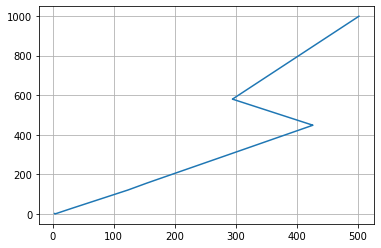

In [14]:
model = baseline_4
model.eval()
model.to("cpu")
learned_field_wrapper = vector_field.TorchToNumpyVectorFieldWrapper(model)
h = utilities.simulate_trajectory(learned_field_wrapper, np.array([3.0, 3.0]), ascending=True, num_iters = 10000, grad_clip=0.1)
plotting.plot_histories([h])

Compare to the original VDP plot

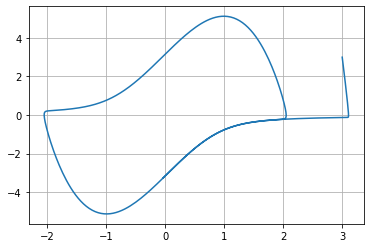

In [11]:
mu = 3.0

def van_der_pol(x: np.ndarray) -> np.ndarray:
    x1, x2 = x[...,0], x[...,1]
    dx1 = x2
    dx2 = mu * (1 - x1 ** 2) * x2 - x1
    dx = np.stack([dx1, dx2], axis=-1)
    return dx

v = vector_field.FunctionalVectorField(van_der_pol)
h = utilities.simulate_trajectory(v, np.array([3.0, 3.0]), ascending=True, num_iters = 2000, grad_clip=1)
plotting.plot_histories([h])

We look into fitting the models using latent state dynamics from a simple circular CPG and using fully parametric CPG  

[154.68115234375, 472.6666717529297, 154.58999633789062, 467.8218231201172, 154.59405517578125, 469.5508117675781, 154.65548706054688, 465.1427307128906, 154.91751098632812, 465.72621154785156]


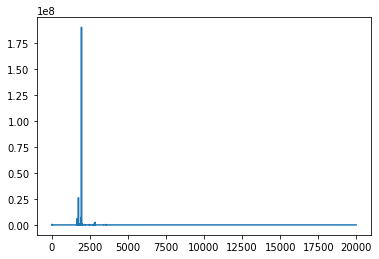

In [15]:
loss_history = train_utils.train(baseline_2, train_loader, learning_rate=1e-4, n_epochs = 5000, grad_clip=5)
import matplotlib.pyplot as plt 
plt.plot(10 * np.arange(len(loss_history)), loss_history)
print(loss_history[-10:])

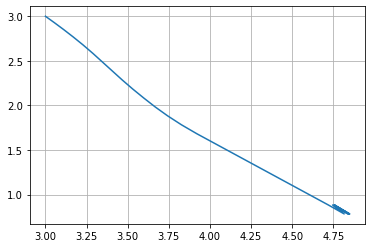

In [16]:
model = baseline_2
model.eval()
model.to("cpu")
learned_field_wrapper = vector_field.TorchToNumpyVectorFieldWrapper(model)
h = utilities.simulate_trajectory(learned_field_wrapper, np.array([3.0, 3.0]), ascending=True, num_iters = 10000, grad_clip=0.1)
plotting.plot_histories([h])

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


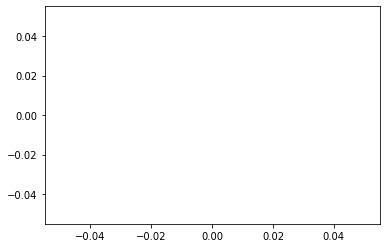

In [17]:
loss_history = train_utils.train(full_net, train_loader, learning_rate=1e-4, n_epochs = 5000, grad_clip=5)
import matplotlib.pyplot as plt 
plt.plot(10 * np.arange(len(loss_history)), loss_history)
print(loss_history[-10:])

In [ ]:
model = full_net
model.eval()
model.to("cpu")
learned_field_wrapper = vector_field.TorchToNumpyVectorFieldWrapper(model)
h = utilities.simulate_trajectory(learned_field_wrapper, np.array([3.0, 3.0]), ascending=True, num_iters = 10000, grad_clip=0.1)
plotting.plot_histories([h])